In [ ]:
!git clone https://github.com/GalAvineri/ISIC-Archive-Downloader
!python /content/ISIC-Archive-Downloader/download_single_item.py
!python /content/ISIC-Archive-Downloader/download_archive.py --num-images 5000

In [ ]:
!pip install giotto-tda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gtda.images  
import gtda.homology
import gtda.diagrams
import json 
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import pandas as pd
from skimage.morphology import convex_hull_image

In [ ]:
def imdetails(i):
  j = 7 - len(str(i))
  l = "0"
  for k in range(1,j):
    l = l + "0"
  l = l + str(i)
  path = "/content/Data/Descriptions/ISIC_" + l
  with open(path) as f: 
    data = f.read()  
  js = json.loads(data)  
  it = ((js.get("meta")).get("acquisition")).get("image_type")
  px = ((js.get("meta")).get("acquisition")).get("pixelsX")
  py = ((js.get("meta")).get("acquisition")).get("pixelsY")
  return [it,px,py]

In [ ]:
def details(i):
  j = 7 - len(str(i))
  l = "0"
  for k in range(1,j):
    l = l + "0"
  l = l + str(i)
  path = "/content/Data/Descriptions/ISIC_" + l
  with open(path) as f: 
    data = f.read()  
  js = json.loads(data)  
  mal = ((js.get("meta")).get("clinical")).get("diagnosis")
  return mal

In [ ]:
description = []
for i in range(0,50):
  description.append(details(i))

In [ ]:
def show_image(i):
  j = 7 - len(str(i))
  l = "0"
  for k in range(1,j):
    l = l + "0"
  l = l + str(i)
  image = plt.imread("/content/Data/Images/ISIC_"+l+".jpeg")
  plt.imshow(image)

In [ ]:
def return_image(i):
  j = 7 - len(str(i))
  l = "0"
  for k in range(1,j):
    l = l + "0"
  l = l + str(i)
  image = plt.imread("/content/Data/Images/ISIC_"+l+".jpeg")
  return image

In [ ]:
#Image Segmentation: Step 1
def avg_intensity(i):
  img = return_image(i)
  sh = np.shape(img)
  r = img[:,:,0]
  g = img[:,:,1]
  b = img[:,:,2]
  ret = np.zeros(np.shape(r))
  for i in range(0,np.shape(r)[0]):
      for j in range(np.shape(r)[1]):
        ret[i,j] = int((int(r[i,j])+int(g[i,j])+int(b[i,j]))/3.0)
  return ret

In [ ]:
def get_alpha(ret):
  return int((np.ravel(ret)).mean())

In [ ]:
def img_thresh(i, t ,T = 50):
  ret = avg_intensity(i)
  alpha = get_alpha(ret)
  val = alpha*(1.0 - (t/T))
  sh = np.shape(ret)
  r = np.zeros(sh)
  for i in range(0, sh[0]):
    for j in range(0, sh[1]):
      r[i,j] = 255*(ret[i,j] <= val)
  return r

In [ ]:
def get_T(i):
  pre = 255 - img_thresh(i, t = 1)
  [x,y] = np.shape(pre)
  diagrams = gtda.homology.CubicalPersistence(homology_dimensions=[0], reduced_homology= False).fit_transform(pre.reshape(1,x,y))
  conn_pre = len(diagrams[0])
  #print(1, "conn = ", conn_pre)
  for k in range(2,50):
    post = 255 - img_thresh(i,t = k)
    diagrams = gtda.homology.CubicalPersistence(homology_dimensions=[0], reduced_homology= False).fit_transform(post.reshape(1,x,y))
    conn_post = len(diagrams[0])  
    #print(k, "conn =", conn_post)  
    if conn_post > conn_pre:
      return 1 + int(k/4)
    conn_pre = conn_post
  return 1 + int(50/4)

In [ ]:
def get_lifescore(i):
  s_1 = img_thresh(i, t = 1)
  [x,y] = np.shape(s_1)
  lifescore = np.zeros((x,y))
  for j in range(2,50):
    s_2 = img_thresh(i, t = j)
    add = ((s_1 - s_2) == 255)
    lifescore = lifescore + add*(j-1)
    s_1 = s_2
    #print(j)
  add = (s_2 == 255)*50
  lifescore = lifescore + add
  return lifescore

In [ ]:
def get_con_hull(i):
  T = get_T(i)
  all_labels = measure.label(img_thresh(0, t = T), background=0)
  lifescores = get_lifescore(i)
  [x,y] = np.shape(lifescores)
  
  o = int(x/2)
  p = int(y/2)
  dist_border = [[ min([i, x-1-i, j, y-1-j]) for j in range(0,y)] for i in range(0,x)]
  dist_center = [[np.linalg.norm(np.array([o,p]) - np.array([i,j])) for j in range(0,y)] for i in range(0,x)]

  life_comp = []
  sum_part = []
  border_part = []
  center_part = []

  for j in range(1, all_labels.max()+1):
    #print(j)
    t = np.ravel(np.multiply((all_labels == j)*1, lifescores))
    sum_part.append(t.sum())
    b = np.ravel(np.multiply((all_labels == j)*1, dist_border))
    b_1 = b[b != 0].min()
    border_part.append(b_1)
    c = np.ravel(np.multiply((all_labels == j)*1, dist_center))
    c_1 = c[c != 0].min()
    center_part.append(c_1)
  
  for j in range(0, len(sum_part)):
    k = (((1 + border_part[j])**3)*(sum_part[j]))/((1+center_part[j])**3)
    life_comp.append(k)

  avg = np.array(life_comp).mean()
  comp = []

  for j in range(0, len(sum_part)):
    if life_comp[j] >= avg:
      comp.append(j+1)

  convex_img = np.zeros((x,y))
  for j in comp:
    convex_img = convex_img + 1*(all_labels == j)
  
  convex_hull = convex_hull_image(convex_img)
  return convex_hull

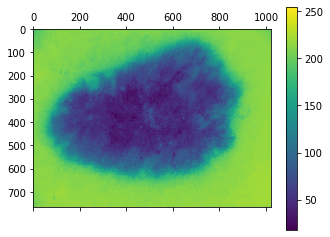

In [ ]:
plt.matshow(avg_intensity(0));
plt.colorbar()
a = get_alpha(avg_intensity(0))

In [ ]:
(avg_intensity(0).ravel()).mean()

149.97988197082694

In [ ]:
np.shape(a)

()

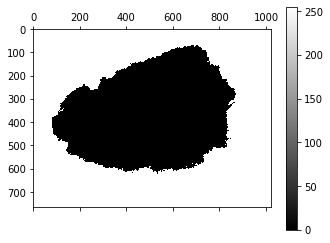

In [ ]:
k = 255 - img_thresh(0, t = 9)
[x,y] = np.shape(k)
plt.matshow(k, cmap=plt.get_cmap('gray'));
plt.colorbar()

In [ ]:
diagrams = gtda.homology.CubicalPersistence(homology_dimensions=[0], reduced_homology= False).fit_transform(k.reshape(1,x,y))

In [ ]:
len(diagrams[0])

20

In [ ]:
all_labels = measure.label(img_thresh(0, t = 9), background=0)

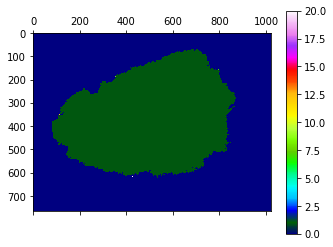

In [ ]:
plt.matshow(all_labels, cmap=plt.get_cmap('gist_ncar'));
plt.colorbar()

In [ ]:
all_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
im = (all_labels == 1)

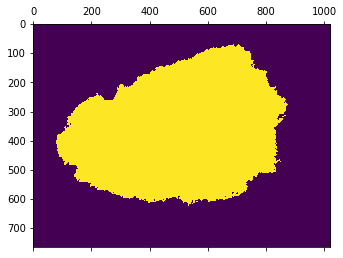

In [ ]:
plt.matshow(im)

In [ ]:
get_T(0)

2

In [ ]:
a = img_thresh(0, t = 0)

In [ ]:
b = img_thresh(0, t = 1)

In [ ]:
c = img_thresh(0, t = 2)

In [ ]:
d = a-b
e = b-c

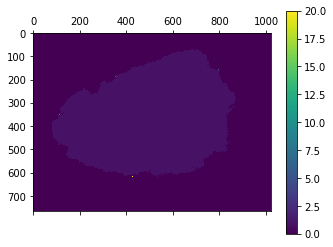

In [ ]:
plt.matshow(all_labels);
plt.colorbar()

In [ ]:
all_labels.max()

20

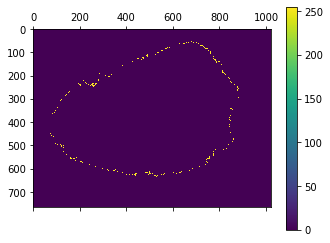

In [ ]:
plt.matshow(a-b);
plt.colorbar()

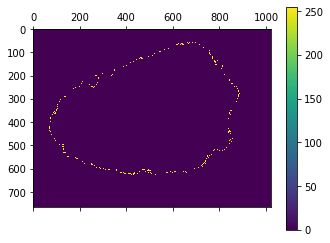

In [ ]:
plt.matshow(b-c);
plt.colorbar()

In [ ]:
test = (d == 255) 

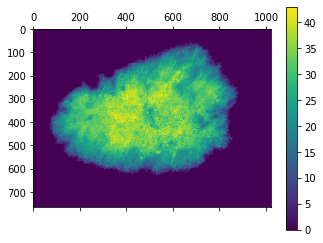

In [ ]:
plt.matshow(a);
plt.colorbar()